In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from scipy.stats import norm, skew

# Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import xlsxwriter

In [1417]:
train = pd.read_excel('../Data_Train.xlsx')

In [1418]:
train.shape

(12690, 9)

In [1419]:
train.head()

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300


In [1420]:
def missing_vals(dataset):
    null_columns=dataset.columns[dataset.isnull().any()]
    print(dataset[null_columns].isnull().sum())

In [1421]:
missing_vals(train)

CITY         112
LOCALITY      98
RATING         2
VOTES       1204
dtype: int64


In [1422]:
train.drop(['RESTAURANT_ID', 'TIME'], axis=1, inplace=True)

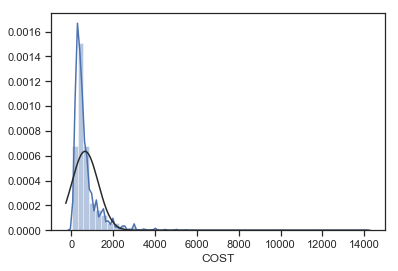

In [1423]:
# Check for skewness in target data
sns.distplot(train['COST'] , fit=norm);

# Target is highly skewed

In [1424]:
# Correct the skewness in target
train['LOG_COST'] = np.log10(train['COST'])

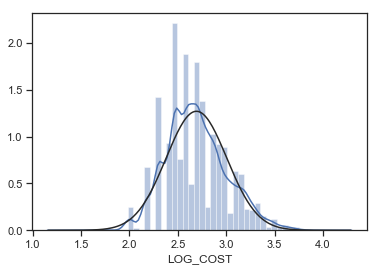

In [1425]:
# Check for skewness in the log transformed column
sns.distplot(train['LOG_COST'] , fit=norm);

In [1426]:
# Drop the original COST column
train.drop('COST', axis=1, inplace=True)

In [1427]:
train.head()

,TITLE,CUISINES,CITY,LOCALITY,RATING,VOTES,LOG_COST
0,CASUAL DINING,"Malwani, Goan, North Indian",Thane,Dombivali East,3.6,49 votes,3.079181
1,"CASUAL DINING,BAR","Asian, Modern Indian, Japanese",Chennai,Ramapuram,4.2,30 votes,3.176091
2,CASUAL DINING,"North Indian, Chinese, Biryani, Hyderabadi",Chennai,Saligramam,3.8,221 votes,2.903090
3,QUICK BITES,"Tibetan, Chinese",Mumbai,Bandra West,4.1,24 votes,2.903090
4,DESSERT PARLOR,Desserts,Mumbai,Lower Parel,3.8,165 votes,2.477121


In [1428]:
############################################ EDA ############################################

In [1429]:
## Column 1: TITLE

In [1430]:
train.loc[(train['TITLE'] == 'None') & (train['CUISINES'].str.contains('Fast Food|Burger|Sandwich|Street Food') == True), 'TITLE'] = 'QUICK BITES'
train.loc[(train['TITLE'] == 'None') & (train['CUISINES'] == 'Beverages'), 'TITLE'] = 'BEVERAGE SHOP'
train.loc[(train['TITLE'] == 'None') & (train['CUISINES'] == 'Bakery'), 'TITLE'] = 'BAKERY'
train.loc[train['TITLE'] == 'None', 'TITLE'] = 'UNKNOWN'

In [1431]:
# Get all unique titles
titles = train['TITLE'].unique()

In [1432]:
# Retrieve each title present in every individual title which is comma seperated
all_titles = [val for sublist in titles for val in sublist.split(',')] 
unique_titles = set(all_titles)

In [1433]:
train['FOOD_PLACE'] = 0
train['FOOD_PLACE'] =  train['TITLE'].apply(lambda x: 1 if x.find('FINE DINING') != -1 or
                                            x.find('CASUAL DINING') != -1 or
                                            x.find('FOOD COURT') != -1 or
                                            x.find('FOOD TRUCK') != -1 or
                                            x.find('QUICK BITES') != -1 or
                                            x.find('DHABA') != -1 or
                                            x.find('MESS') != -1 or
                                            x.find('UNKNOWN') != -1
                                            else 0
                                           )

In [1434]:
train['PARTY_PLACE'] = 0
train['PARTY_PLACE'] =  train['TITLE'].apply(lambda x: 1 if x.find('CLUB') != -1 or
                                            x.find('PUB') != -1 or
                                            x.find('LOUNGE') != -1
                                            else 0
                                           )

In [1435]:
train['DRINKS_PLACE'] = 0
train['DRINKS_PLACE'] =  train['TITLE'].apply(lambda x: 1 if x.find('MICROBREWERY') != -1 or
                                            x.find('COCKTAIL BAR') != -1 or
                                            x.find('BAR') != -1
                                            else 0
                                           )

In [1436]:
train['IS_SHOP'] = 0
train['IS_SHOP'] =  train['TITLE'].apply(lambda x: 1 if x.find('SHOP') != -1 else 0)

In [1437]:
train['BAKERY_CAFE'] = 0
train['BAKERY_CAFE'] =  train['TITLE'].apply(lambda x: 1 if x.find('BAKERY') != -1 or
                                            x.find('CAF') != -1 or
                                            x.find('DESSERT') != -1 or
                                            x.find('CONFECTION') != -1
                                            else 0
                                           )

In [1438]:
train['FOOD_DRINKS_PARTY'] = 999
train['FOOD_DRINKS_PARTY'] = train['FOOD_PLACE'] + train['PARTY_PLACE'] + train['DRINKS_PLACE']

In [1439]:
train['DINING_RANK'] = 999
train['DINING_RANK'] = train['TITLE'].apply(lambda x: 1 if x.find('FINE DINING') != -1 
                                            else (2 if x.find('CASUAL DINING') != -1 
                                            else (3 if x.find('FOOD COURT') != -1 
                                            else (4 if x.find('QUICK BITES') != -1 
                                            else (5 if x.find('FOOD TRUCK') != -1                                             
                                            else (6 if x.find('DHABA') != -1
                                            else (7 if x.find('MESS') != -1
                                            else 999
                                            )))))))

In [1440]:
train.head()

,TITLE,CUISINES,CITY,LOCALITY,RATING,VOTES,LOG_COST,FOOD_PLACE,PARTY_PLACE,DRINKS_PLACE,IS_SHOP,BAKERY_CAFE,FOOD_DRINKS_PARTY,DINING_RANK
0,CASUAL DINING,"Malwani, Goan, North Indian",Thane,Dombivali East,3.6,49 votes,3.079181,1,0,0,0,0,1,2
1,"CASUAL DINING,BAR","Asian, Modern Indian, Japanese",Chennai,Ramapuram,4.2,30 votes,3.176091,1,0,1,0,0,2,2
2,CASUAL DINING,"North Indian, Chinese, Biryani, Hyderabadi",Chennai,Saligramam,3.8,221 votes,2.903090,1,0,0,0,0,1,2
3,QUICK BITES,"Tibetan, Chinese",Mumbai,Bandra West,4.1,24 votes,2.903090,1,0,0,0,0,1,4
4,DESSERT PARLOR,Desserts,Mumbai,Lower Parel,3.8,165 votes,2.477121,0,0,0,0,1,0,999


In [1441]:
## Column 2: CUISINES

In [1442]:
# Get all unique cuisines
cuisines = train['CUISINES'].unique()

In [1443]:
all_cuisines = [val.strip(' ') for sublist in cuisines for val in sublist.split(',')] 
unique_cuisines = set(all_cuisines)

In [1444]:
unique_cuisines.remove('')

In [1445]:
for cuisine in unique_cuisines:
    new_col = 'CUISINE_' + cuisine
    train[new_col] = 0
    train[new_col] = train['CUISINES'].apply(lambda x: 0 if x.find(cuisine) == -1 else 1)

In [1446]:
train['CUISINE_MULTI'] = train['CUISINES'].apply(lambda x: 0 if x.find(',') == -1 else 1)

In [1447]:
train.head()

,TITLE,CUISINES,CITY,LOCALITY,RATING,VOTES,LOG_COST,FOOD_PLACE,PARTY_PLACE,DRINKS_PLACE,...,CUISINE_Raw Meats,CUISINE_Fusion,CUISINE_Kashmiri,CUISINE_Mexican,CUISINE_Spanish,CUISINE_Tex-Mex,CUISINE_French,CUISINE_Peruvian,CUISINE_Asian,CUISINE_MULTI
0,CASUAL DINING,"Malwani, Goan, North Indian",Thane,Dombivali East,3.6,49 votes,3.079181,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,"CASUAL DINING,BAR","Asian, Modern Indian, Japanese",Chennai,Ramapuram,4.2,30 votes,3.176091,1,0,1,...,0,0,0,0,0,0,0,0,1,1
2,CASUAL DINING,"North Indian, Chinese, Biryani, Hyderabadi",Chennai,Saligramam,3.8,221 votes,2.903090,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,QUICK BITES,"Tibetan, Chinese",Mumbai,Bandra West,4.1,24 votes,2.903090,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,DESSERT PARLOR,Desserts,Mumbai,Lower Parel,3.8,165 votes,2.477121,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1448]:
## Column 3: RATING

In [1449]:
# Create a subset of train with records having not null values for RATING
sub = train[pd.notnull(train['RATING'])]

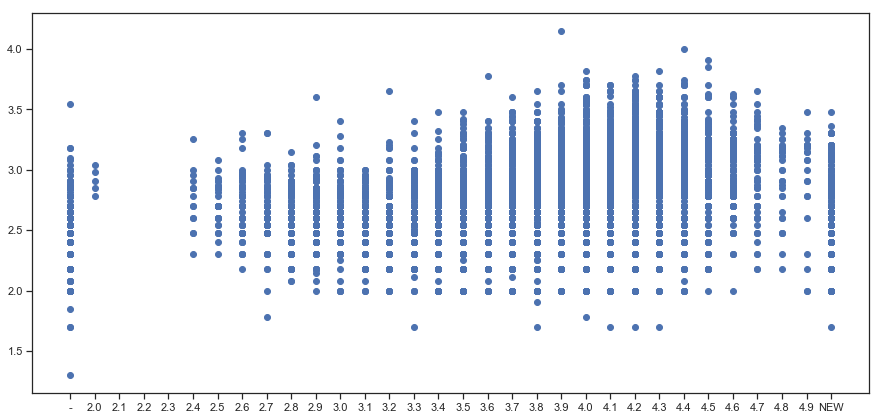

In [1450]:
plt.figure(figsize=(15,7))
plt.scatter(sub['RATING'], sub['LOG_COST'])
plt.show()

In [1453]:
sub_rating = sub[(sub['RATING'] != '-') & (sub['RATING'] != 'NEW')]
rating_median = sub_rating['RATING'].median()
rating_median

3.8

In [1454]:
# Drop records with RATING = NaN
#train = train[pd.notnull(train['RATING'])]
train['RATING'] = train['RATING'].fillna(rating_median)

In [1455]:
# Add a new column, 'IS_NEW' if the restaurant is new
train['IS_NEW'] = 0
train.loc[train['RATING'] == 'NEW', 'IS_NEW'] = 1
train.loc[train['RATING'] == 'NEW', 'VOTES'] = 0

In [1456]:
train['NOT_RATED'] = 0
train.loc[train['RATING'] == '-', 'NOT_RATED'] = 1
train.loc[train['RATING'] == '-', 'VOTES'] = 0

In [1457]:
train['RATING'] = train['RATING'].apply(lambda x: rating_median if x == 'NEW' else x)
train['RATING'] = train['RATING'].apply(lambda x: rating_median if x == '-' else x)

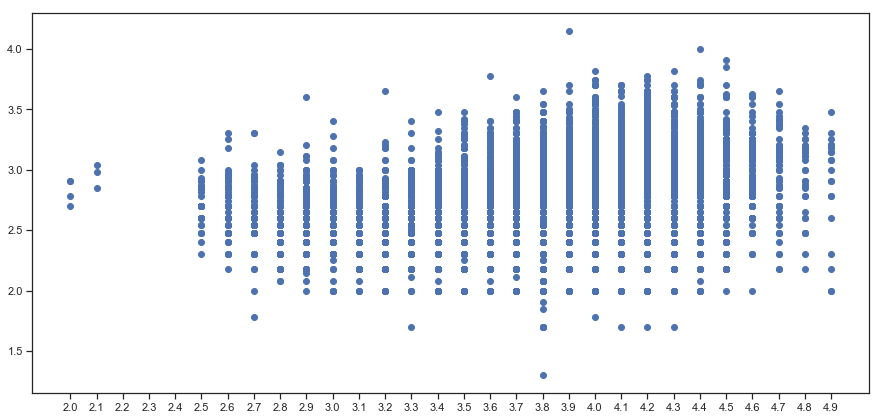

In [1458]:
plt.figure(figsize=(15,7))
plt.scatter(train['RATING'], train['LOG_COST'])
plt.show()

In [1462]:
train['RATING'] = train['RATING'].astype(float)

In [1463]:
bins = [1, 2, 3, 4, 5]
labels = ['RT_1_to_2', 'RT_2_to_3', 'RT_3_to_4', 'RT_4_to_5']
train['RATING_BINNED'] = pd.cut(train['RATING'], bins=bins, labels=labels)

#bins=[1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
#labels = ['RT_1_1.5', 'RT_1.5_2', 'RT_2_2.5', 'RT_2.5_3', 'RT_3_3.5', 'RT_3.5_4', 'RT_4_4.5', 'RT_4.5_5']
#train['RATING_BINNED'] = pd.cut(train['RATING'], bins=bins, labels=labels)

#percentiles = [0, .25, .5, .75, 1]
#labels  = ['RT_1st_quart', 'RT_2nd_quart', 'RT_3rd_quart', 'RT_4th_quart']
#train['RATING_BINNED'] = pd.qcut(train['RATING'], percentiles, labels=labels)

In [1464]:
train['RATING_BINNED'].unique()

[RT_3_to_4, RT_4_to_5, RT_2_to_3, RT_1_to_2]
Categories (4, object): [RT_1_to_2 < RT_2_to_3 < RT_3_to_4 < RT_4_to_5]

In [1465]:
## Column 4: CITY

In [1466]:
train['CITY'] = train['CITY'].str.replace('Bengaluru','Bangalore')
train['CITY'] = train['CITY'].str.replace('Bengalore','Bangalore')
train['CITY'] = train['CITY'].str.replace('India','Unknown')

In [1467]:
train['CITY'] = train['CITY'].fillna('Unknown')

In [1468]:
df = train.groupby('CITY').size().reset_index(name='count')
df = df.sort_values('count', ascending=False)
cities = df[df['count']> 6]['CITY']
cities = list(cities)
cities

['Bangalore',
 'Chennai',
 'Hyderabad',
 'Mumbai',
 'New Delhi',
 'Kochi',
 'Gurgaon',
 'Secunderabad',
 'Noida',
 'Navi Mumbai',
 'Unknown',
 'Ghaziabad',
 'Thane',
 'Faridabad',
 'Bandra West',
 'Thane West',
 'Andheri West',
 'Greater Noida',
 'Kakkanad',
 'Ernakulam',
 'Kerala',
 'Dwarka',
 'Delhi NCR',
 'Delhi',
 'Telangana',
 'Edappally',
 'Hyderabad.',
 'Gurugram']

In [1469]:
train['CITY'] = train['CITY'].astype(str)

In [1470]:
train['CITY'] = train['CITY'].apply(lambda x: x if x in cities else 'Other')

In [1471]:
cities.append('Other')

In [1472]:
for city in cities:
    new_col = 'CITY_' + city
    train[new_col] = 0
    train[new_col] = train['CITY'].apply(lambda x: 0 if x.find(city) == -1 else 1)

In [1473]:
train['IS_TIER_1'] = 0
train['IS_TIER_1'] = train['CITY'].apply(lambda x: 1 if (x.find('Bangalore') != -1 or
                                         x.find('Chennai') != -1 or
                                         x.find('Delhi') != -1 or
                                         x.find('Hyderabad') != -1 or
                                         x.find('Mumbai') != -1 or
                                         x.find('Kolkata') != -1)
                                         else 0
                                        )                                        

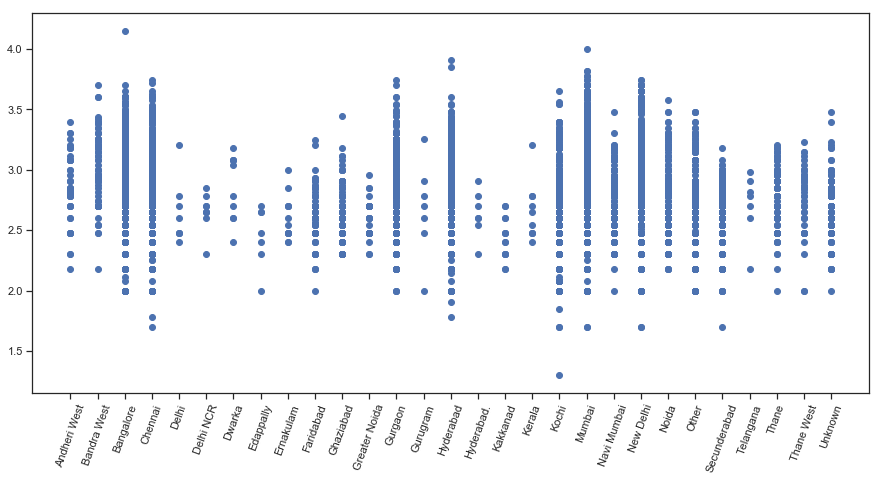

In [1474]:
plt.figure(figsize=(15,7))
plt.scatter(train['CITY'], train['LOG_COST'])
plt.xticks(rotation=70)
plt.show()

In [1475]:
## Column 6: LOCALITY

In [1476]:
train['LOCALITY'] = train['LOCALITY'].fillna('Unknown')

df = train.groupby('LOCALITY').size().reset_index(name='count')
df = df.sort_values('count', ascending=False)
localities = df[df['count']> 50]['LOCALITY']
localities = list(localities)
localities

['Gachibowli',
 'Indiranagar',
 'Edappally',
 'Kakkanad',
 'HSR',
 'Kukatpally',
 'Madhapur',
 'Marathahalli',
 'Jubilee Hills',
 'Banjara Hills',
 'Whitefield',
 'Fort Kochi',
 'BTM',
 'Unknown',
 'Jayanagar',
 'Nungambakkam',
 'MG Road',
 'T. Nagar',
 'Kaloor',
 'Andheri West',
 'Kondapur',
 'JP Nagar',
 'Borivali West',
 'Anna Nagar East',
 'Koramangala 5th Block',
 'Connaught Place',
 'Electronic City',
 'Thane West',
 'Velachery',
 'Malad West',
 'Lower Parel',
 'Hitech City',
 'Mira Road',
 'Vyttila',
 'Rohini',
 'Adyar',
 'Powai',
 'Bandra West',
 'Anna Nagar West',
 'Juhu',
 'Kilpauk',
 'Palarivattom']

In [1477]:
train['LOCALITY'] = train['LOCALITY'].astype(str)
train['LOCALITY'] = train['LOCALITY'].apply(lambda x: x if x in localities else 'Other')
localities.append('Other')

In [1478]:
for each in localities:
    new_col = 'LOCALITY_' + each
    train[new_col] = 0
    train[new_col] = train['LOCALITY'].apply(lambda x: 0 if x.find(each) == -1 else 1)

In [1479]:
## Column 5: VOTES

In [1480]:
train['VOTES'] = train['VOTES'].str.replace(' votes', '')

In [1481]:
votes_median = train['VOTES'].median()
votes_median

163.0

In [1482]:
train['VOTES'] = train['VOTES'].fillna(votes_median)
train['VOTES'] = train['VOTES'].astype(int)

In [1483]:
train['VOTES'].max()

41186

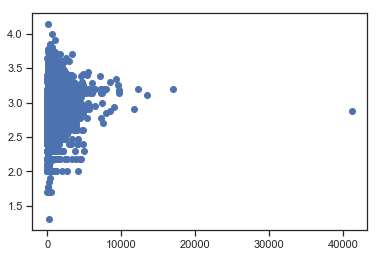

In [1484]:
plt.scatter(train['VOTES'], train['LOG_COST'])
# Outlier found

In [1485]:
# Remove outlier
train = train[train.VOTES < 40000]

In [1486]:
# Binning VOTES column
percentiles = [0, .25, .5, .75, 1]
labels  = ['VOTES_1st_quart', 'VOTES_2nd_quart', 'VOTES_3rd_quart', 'VOTES_4th_quart']
train['VOTES_BINNED'] = pd.qcut(train['VOTES'], percentiles, labels=labels)

#bins = [1, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 20000]
#labels=['VT1', 'VT2', 'VT3', 'VT4', 'VT5', 'VT6', 'VT7', 'VT8']
#train['VOTES_BINNED'] = pd.cut(train['VOTES'], bins=bins, labels=labels)

c:\python36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [1487]:
# Dummies
X_dummies1 = pd.get_dummies(train['VOTES_BINNED'])
X_dummies2 = pd.get_dummies(train['RATING_BINNED'])

In [1488]:
train = pd.concat([train,X_dummies1], axis=1)
train = pd.concat([train,X_dummies2], axis=1)

In [1489]:
train.drop('TITLE', axis=1, inplace=True)
train.drop('CUISINES', axis=1, inplace=True)
train.drop('RATING', axis=1, inplace=True)
train.drop('CITY', axis=1, inplace=True)
train.drop('LOCALITY', axis=1, inplace=True)
train.drop('VOTES', axis=1, inplace=True)
train.drop(['VOTES_BINNED'], axis=1, inplace=True)
train.drop(['RATING_BINNED'], axis=1, inplace=True)

In [1490]:
y = train['LOG_COST'].values
X = train.drop(['LOG_COST'], axis=1)

In [1491]:
X.head()

,FOOD_PLACE,PARTY_PLACE,DRINKS_PLACE,IS_SHOP,BAKERY_CAFE,FOOD_DRINKS_PARTY,DINING_RANK,CUISINE_Jewish,CUISINE_BBQ,CUISINE_Nepalese,...,LOCALITY_Palarivattom,LOCALITY_Other,VOTES_1st_quart,VOTES_2nd_quart,VOTES_3rd_quart,VOTES_4th_quart,RT_1_to_2,RT_2_to_3,RT_3_to_4,RT_4_to_5
0,1,0,0,0,0,1,2,0,0,0,...,0,1,1,0,0,0,0,0,1,0
1,1,0,1,0,0,2,2,0,0,0,...,0,1,1,0,0,0,0,0,0,1
2,1,0,0,0,0,1,2,0,0,0,...,0,1,0,0,1,0,0,0,1,0
3,1,0,0,0,0,1,4,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,1,0,999,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [1492]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)

In [1493]:
'''
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
'''

'\nfrom sklearn.preprocessing import StandardScaler\n\nsc = StandardScaler()\nX_train = sc.fit_transform(X_train)\nX_test = sc.transform(X_test)\n'

In [1494]:
######## Modelling

clf = LinearRegression()
clf.fit(X_train, y_train)
y_pred_lr = clf.predict(X_test)

In [1495]:
# Compute the rmse: rmse
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(rmse_lr)
print(1-rmse_lr)

4517728.385481343
-4517727.385481343


In [1496]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [1497]:
# Compute the rmse: rmse
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
print(rmse_dt)
print(1-rmse_dt)

0.20758551925108096
0.7924144807489191


In [1498]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [1500]:
# Compute the rmse: rmse
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(rmse_rf)
print(1-rmse_rf)

0.16628056529596458
0.8337194347040354


In [1501]:
gb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01,
                                   max_depth=10, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

In [1502]:
# Compute the rmse: rmse
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print(rmse_gb)
print(1-rmse_gb)

0.1534109325071776
0.8465890674928224


In [1503]:
'''
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(n_estimators=3000,
                                   criterion='mse',
                                   max_features='sqrt',
                                   max_depth=10,
                                   min_samples_split=10,
                                   min_samples_leaf=15,
                                   random_state=5)
etr.fit(X_train, y_train)
y_pred_etr = etr.predict(X_test)

# Compute the rmse: rmse
rmse_etr = np.sqrt(mean_squared_error(y_test, y_pred_etr))
print(rmse_etr)
print(1-rmse_etr)
'''

"\nfrom sklearn.ensemble import ExtraTreesRegressor\n\netr = ExtraTreesRegressor(n_estimators=3000,\n                                   criterion='mse',\n                                   max_features='sqrt',\n                                   max_depth=10,\n                                   min_samples_split=10,\n                                   min_samples_leaf=15,\n                                   random_state=5)\netr.fit(X_train, y_train)\ny_pred_etr = etr.predict(X_test)\n\n# Compute the rmse: rmse\nrmse_etr = np.sqrt(mean_squared_error(y_test, y_pred_etr))\nprint(rmse_etr)\nprint(1-rmse_etr)\n"

In [1504]:
'''
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=1000, max_depth=10, eta=0.01)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# Compute the rmse: rmse
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(rmse_xgb)
print(1-rmse_xgb)
'''

'\nfrom xgboost import XGBRegressor\n\nxgb = XGBRegressor(n_estimators=1000, max_depth=10, eta=0.01)\nxgb.fit(X_train, y_train)\ny_pred_xgb = xgb.predict(X_test)\n\n# Compute the rmse: rmse\nrmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))\nprint(rmse_xgb)\nprint(1-rmse_xgb)\n'

In [1505]:
'''
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor

xgbr = XGBRegressor()
rf = RandomForestRegressor(n_estimators=100, random_state=1)
lr = LinearRegression()

stack = StackingCVRegressor(regressors=(xgbr ,rf, lr),meta_regressor= xgbr)
stack.fit(X_train, y_train)

y_pred_stack = stack.predict(X_test)

# Compute the rmse: rmse
rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
print(rmse_stack)
print(1-rmse_stack)

'''

'\nfrom mlxtend.regressor import StackingCVRegressor\nfrom xgboost import XGBRegressor\n\nxgbr = XGBRegressor()\nrf = RandomForestRegressor(n_estimators=100, random_state=1)\nlr = LinearRegression()\n\nstack = StackingCVRegressor(regressors=(xgbr ,rf, lr),meta_regressor= xgbr)\nstack.fit(X_train, y_train)\n\ny_pred_stack = stack.predict(X_test)\n\n# Compute the rmse: rmse\nrmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))\nprint(rmse_stack)\nprint(1-rmse_stack)\n\n'

In [1506]:
########### Loading test data

In [1507]:
test = pd.read_excel('C:/Users/hianj/Desktop/DataCamp Learnings/Machine Hack/Restaurant_Food_Cost/data/Data_Test.xlsx')

In [1508]:
test.drop(['RESTAURANT_ID', 'TIME'], axis=1, inplace=True)

In [1509]:
test.isnull().sum()

TITLE         0
CUISINES      0
CITY         35
LOCALITY     30
RATING        2
VOTES       402
dtype: int64

In [1510]:
test.loc[(test['TITLE'] == 'None') & (test['CUISINES'].str.contains('Fast Food|Burger|Sandwich|Street Food') == True), 'TITLE'] = 'QUICK BITES'
test.loc[(test['TITLE'] == 'None') & (test['CUISINES'] == 'Beverages'), 'TITLE'] = 'BEVERAGE SHOP'
test.loc[(test['TITLE'] == 'None') & (test['CUISINES'] == 'Bakery'), 'TITLE'] = 'BAKERY'
test.loc[test['TITLE'] == 'None', 'TITLE'] = 'UNKNOWN'

In [1511]:
test['FOOD_PLACE'] = 0
test['FOOD_PLACE'] =  test['TITLE'].apply(lambda x: 1 if x.find('FINE DINING') != -1 or
                                            x.find('CASUAL DINING') != -1 or
                                            x.find('FOOD COURT') != -1 or
                                            x.find('FOOD TRUCK') != -1 or
                                            x.find('QUICK BITES') != -1 or
                                            x.find('DHABA') != -1 or
                                            x.find('MESS') != -1 or
                                            x.find('UNKNOWN') != -1
                                            else 0
                                           )

test['PARTY_PLACE'] = 0
test['PARTY_PLACE'] =  test['TITLE'].apply(lambda x: 1 if x.find('CLUB') != -1 or
                                            x.find('PUB') != -1 or
                                            x.find('LOUNGE') != -1
                                            else 0
                                           )

test['DRINKS_PLACE'] = 0
test['DRINKS_PLACE'] =  test['TITLE'].apply(lambda x: 1 if x.find('MICROBREWERY') != -1 or
                                            x.find('COCKTAIL BAR') != -1 or
                                            x.find('BAR') != -1
                                            else 0
                                           )

test['IS_SHOP'] = 0
test['IS_SHOP'] =  test['TITLE'].apply(lambda x: 1 if x.find('SHOP') != -1 else 0)

test['BAKERY_CAFE'] = 0
test['BAKERY_CAFE'] =  test['TITLE'].apply(lambda x: 1 if x.find('BAKERY') != -1 or
                                            x.find('CAF') != -1 or
                                            x.find('DESSERT') != -1 or
                                            x.find('CONFECTION') != -1
                                            else 0
                                           )

test['FOOD_DRINKS_PARTY'] = 999
test['FOOD_DRINKS_PARTY'] = test['FOOD_PLACE'] + test['PARTY_PLACE'] + test['DRINKS_PLACE']

test['DINING_RANK'] = 999
test['DINING_RANK'] = test['TITLE'].apply(lambda x: 1 if x.find('FINE DINING') != -1 
                                            else (2 if x.find('CASUAL DINING') != -1 
                                            else (3 if x.find('FOOD COURT') != -1 
                                            else (4 if x.find('QUICK BITES') != -1 
                                            else (5 if x.find('FOOD TRUCK') != -1                                             
                                            else (6 if x.find('DHABA') != -1
                                            else (7 if x.find('MESS') != -1
                                            else 999
                                            )))))))

In [1512]:
for cuisine in unique_cuisines:
    new_col = 'CUISINE_' + cuisine
    test[new_col] = 0
    test[new_col] = test['CUISINES'].apply(lambda x: 0 if x.find(cuisine) == -1 else 1)

test['CUISINE_MULTI'] = test['CUISINES'].apply(lambda x: 0 if x.find(',') == -1 else 1)

In [1513]:
# Add a new column, 'IS_NEW' if the restaurant is new
test['RATING'] = test['RATING'].fillna(rating_median)

test['IS_NEW'] = 0
test.loc[test['RATING'] == 'NEW', 'IS_NEW'] = 1
test.loc[test['RATING'] == 'NEW', 'VOTES'] = 0

test['NOT_RATED'] = 0
test.loc[test['RATING'] == '-', 'NOT_RATED'] = 1
test.loc[test['RATING'] == '-', 'VOTES'] = 0

test['RATING'] = test['RATING'].apply(lambda x: rating_median if x == 'NEW' else x)
test['RATING'] = test['RATING'].apply(lambda x: rating_median if x == '-' else x)

test['RATING'] = test['RATING'].astype(float)

#bins = [1, 2, 3, 4, 5, 999]
#labels = ['RT_1_to_2', 'RT_2_to_3', 'RT_3_to_4', 'RT_4_to_5', 'RT_5_above']
#percentiles = [0, .25, .5, .75, 1]
#labels  = ['RT_1st_quart', 'RT_2nd_quart', 'RT_3rd_quart', 'RT_4th_quart']
#test['RATING_BINNED'] = pd.qcut(test['RATING'], percentiles, labels=labels)

#bins=[1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
#labels = ['RT_1_1.5', 'RT_1.5_2', 'RT_2_2.5', 'RT_2.5_3', 'RT_3_3.5', 'RT_3.5_4', 'RT_4_4.5', 'RT_4.5_5']
bins = [1, 2, 3, 4, 5]
labels = ['RT_1_to_2', 'RT_2_to_3', 'RT_3_to_4', 'RT_4_to_5']
test['RATING_BINNED'] = pd.cut(test['RATING'], bins=bins, labels=labels)

In [1514]:
test['CITY'] = test['CITY'].str.replace('Bengaluru','Bangalore')
test['CITY'] = test['CITY'].str.replace('Bengalore','Bangalore')
test['CITY'] = test['CITY'].str.replace('India','Unknown')

test['CITY'] = test['CITY'].fillna('Unknown')

test['CITY'] = test['CITY'].astype(str)

cities.remove('Other')

test['CITY'] = test['CITY'].apply(lambda x: x if x in cities else 'Other')

cities.append('Other')

for city in cities:
    new_col = 'CITY_' + city
    test[new_col] = 0
    test[new_col] = test['CITY'].apply(lambda x: 0 if x.find(city) == -1 else 1)

test['IS_TIER_1'] = 0
test['IS_TIER_1'] = test['CITY'].apply(lambda x: 1 if (x.find('Bangalore') != -1 or
                                         x.find('Chennai') != -1 or
                                         x.find('Delhi') != -1 or
                                         x.find('Hyderabad') != -1 or
                                         x.find('Mumbai') != -1 or
                                         x.find('Kolkata') != -1)
                                         else 0
                                        )

In [1515]:
test['LOCALITY'] = test['LOCALITY'].fillna('Unknown')

test['LOCALITY'] = test['LOCALITY'].astype(str)

localities.remove('Other')

test['LOCALITY'] = test['LOCALITY'].apply(lambda x: x if x in localities else 'Other')

localities.append('Other')

for each in localities:
    new_col = 'LOCALITY_' + each
    test[new_col] = 0
    test[new_col] = test['LOCALITY'].apply(lambda x: 0 if x.find(each) == -1 else 1)

In [1516]:
test['VOTES'] = test['VOTES'].str.replace(' votes', '')
test['VOTES'] = test['VOTES'].fillna(votes_median)
test['VOTES'] = test['VOTES'].astype(int)

# Binning VOTES column
percentiles = [0, .25, .5, .75, 1]
labels  = ['VOTES_1st_quart', 'VOTES_2nd_quart', 'VOTES_3rd_quart', 'VOTES_4th_quart']
test['VOTES_BINNED'] = pd.qcut(test['VOTES'], percentiles, labels=labels)
#bins = [1, 2000, 4000, 6000, 8000, 10000, 12000, 14000]
#labels=['VT1', 'VT2', 'VT3', 'VT4', 'VT5', 'VT6', 'VT7']
#test['VOTES_BINNED'] = pd.cut(test['VOTES'], bins=bins, labels=labels)

In [1517]:
missing_vals(test)

Series([], dtype: float64)


In [1518]:
#test[test['RATING'].isnull()]

In [1519]:
# Dummies
X_dummies1 = pd.get_dummies(test['VOTES_BINNED'])
X_dummies2 = pd.get_dummies(test['RATING_BINNED'])

test = pd.concat([test,X_dummies1], axis=1)
test = pd.concat([test,X_dummies2], axis=1)

test.drop('TITLE', axis=1, inplace=True)
test.drop('CUISINES', axis=1, inplace=True)
test.drop('RATING', axis=1, inplace=True)
test.drop('CITY', axis=1, inplace=True)
test.drop('LOCALITY', axis=1, inplace=True)
test.drop('VOTES', axis=1, inplace=True)
test.drop(['VOTES_BINNED'], axis=1, inplace=True)
test.drop(['RATING_BINNED'], axis=1, inplace=True)

In [1520]:
predictions = gb.predict(test)

In [1521]:
predictions_exp = [int(10**x) for x in predictions]

In [1522]:
sub = pd.DataFrame()
sub['COST'] = predictions_exp

In [1523]:
sub.head()

,COST
0,1039
1,387
2,688
3,391
4,226


In [1524]:
sub.to_excel('../cost_predictions.xlsx',index=False, engine='xlsxwriter')